## Import libraries

In [1]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [2]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from keras import layers as tfkl
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [3]:
# Import other libraries
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

## Load inspect and process data

**Details:**
- Image size: 96x96
- Color space: RGB
- File Format: npz
- Number of classes: 2
- Classes:
    - 0: "healthy"
    - 1: "unhealthy"

**Structure**
- training: containing the 'public_data.npz' file. The file contains the following items:
    - 'data': 3-dimensional numpy array of shape 5200x96x96x3, containing the RGB images.
    - 'labels': 1-dimensional numpy array of shape 5200 with values in {'healthy', 'unhealthy'}

In [15]:
# Load data
dataset = np.load('data/public_data.npz', allow_pickle=True)
X_train_val = dataset['data']
y_train_val = dataset['labels']
labels = {0:'healthy', 1:'unhealthy'}

In [ ]:
# Inspect the target
print('Counting occurrences of target classes:')
print(pd.DataFrame(y_train_val, columns=['status'])['status'].value_counts())

In [16]:
# convert elements of y_train_val to 0 and 1
y_train_val = np.array([0 if label == 'healthy' else 1 for label in y_train_val])

array([0, 0, 0, ..., 0, 0, 0])

In [17]:
# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

Training-Validation Data Shape: (5200, 96, 96, 3)
Training-Validation Label Shape: (5200,)


In [18]:
# Expand also the labels dimension moving from (x,) to (x, 1), with x cardinality
y_train_val = np.expand_dims(y_train_val, axis=-1)

# Print the shapes of the loaded datasets
print("Training-Validation Data Shape:", X_train_val.shape)
print("Training-Validation Label Shape:", y_train_val.shape)

Training-Validation Data Shape: (5200, 96, 96, 3)
Training-Validation Label Shape: (5200, 1)


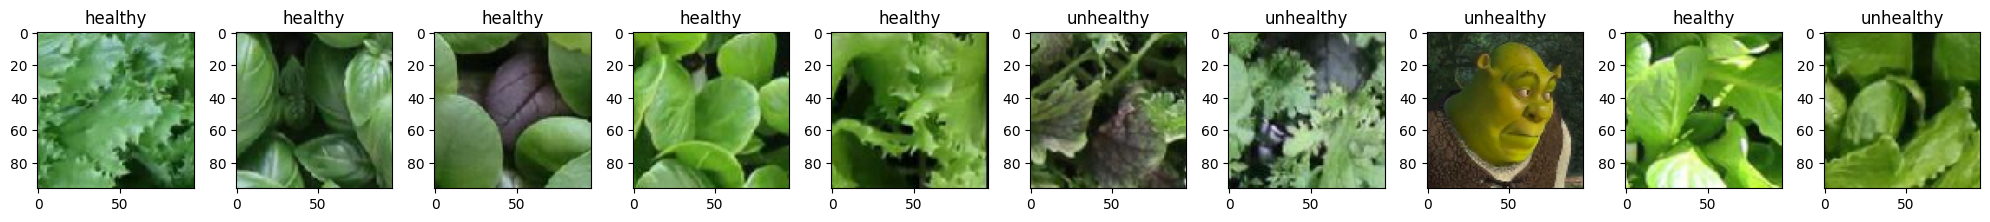

In [20]:
# Display a sample of images from the training-validation dataset
num_img = 10
offset = 200
fig, axes = plt.subplots(1, num_img, figsize=(20, 20))

# Iterate through the selected number of images
for i in range(num_img):
    ax = axes[i % num_img]
    ax.imshow(X_train_val[offset+i].astype(int))
    ax.set_title(f'{labels[y_train_val[offset+i][0]]}')

# Adjust layout and display the images
plt.tight_layout()
plt.show()

In [22]:
# Normalize data to the range [0, 1]
# many types of normalization. tipicamente divido per 255, per portare i valori tra 0 e 1
# ci sono altre opzioni, extra material!
# mean e sd channel-wise
X_train_val = (X_train_val / 255).astype('float32')

# Convert labels to categorical format using one-hot encoding
y_train_val = tfk.utils.to_categorical(y_train_val)

In [24]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, random_state=seed, test_size=0.1, stratify=y_train_val)

# Print the shapes of the resulting datasets
print("Training Data Shape:", X_train.shape)
print("Training Label Shape:", y_train.shape)
print("Validation Data Shape:", X_val.shape)
print("Validation Label Shape:", y_val.shape)

Training Data Shape: (4680, 96, 96, 3)
Training Label Shape: (4680, 2)
Validation Data Shape: (520, 96, 96, 3)
Validation Label Shape: (520, 2)


In [25]:
# Compare categorical label and "default" label representation
print('Categorical label:', y_train[0])           # Display the categorical label
print('"Default" label:', np.argmax(y_train[0]))   # Display the equivalent numeric label

Categorical label: [0. 1.]
"Default" label: 1


In [26]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = y_train.shape[1]  # Output shape for the model
batch_size = 128                # Batch size for training
epochs = 200                     # Number of training epochs

# Print the defined parameters
print("Epochs:", epochs)
print("Batch Size:", batch_size)
print("Input Shape:", input_shape)
print("Output Shape:", output_shape)

Epochs: 200
Batch Size: 128
Input Shape: (96, 96, 3)
Output Shape: 2


In [28]:
def build_quasiVGG9(input_shape, output_shape, seed=seed):
    tf.random.set_seed(seed)

    # 4 convolutional blocks
    # potenze di 2 per i filtri -> è solo una convenzione
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv00')(input_layer)
    x = tfkl.Conv2D(filters=32,kernel_size=3,padding='same',activation='relu',name='conv01')(x)
    x = tfkl.MaxPooling2D(name='mp0')(x)

    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv10')(x)
    x = tfkl.Conv2D(filters=64,kernel_size=3,padding='same',activation='relu',name='conv11')(x)
    x = tfkl.MaxPooling2D(name='mp1')(x)

    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv20')(x)
    x = tfkl.Conv2D(filters=128,kernel_size=3,padding='same',activation='relu',name='conv21')(x)
    x = tfkl.MaxPooling2D(name='mp2')(x)

    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv30')(x)
    x = tfkl.Conv2D(filters=256,kernel_size=3,padding='same',activation='relu',name='conv31')(x)
    x = tfkl.GlobalAveragePooling2D(name='gap')(x) # se kernel dim = filter dim, take the average of the filter
    # prorietà interessanti: invariance..
    # better than flattening in many cases

    output_layer = tfkl.Dense(units=output_shape,activation='softmax',name='Output')(x)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='Convnet')

    # Compile the model
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(weight_decay=5e-4), metrics=['accuracy'])

    # Return the model
    return model

In [29]:
# Build the LeNet model and display its summary
model = build_quasiVGG9(input_shape, output_shape)
model.summary()

Model: "Convnet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 96, 96, 3)]       0         
                                                                 
 conv00 (Conv2D)             (None, 96, 96, 32)        896       
                                                                 
 conv01 (Conv2D)             (None, 96, 96, 32)        9248      
                                                                 
 mp0 (MaxPooling2D)          (None, 48, 48, 32)        0         
                                                                 
 conv10 (Conv2D)             (None, 48, 48, 64)        18496     
                                                                 
 conv11 (Conv2D)             (None, 48, 48, 64)        36928     
                                                                 
 mp1 (MaxPooling2D)          (None, 24, 24, 64)        0   

### Train the model

In [30]:
# Define early stopping callback
early_stopping = tfk.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

# Train the model and save its history
history = model.fit(
    x=X_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping]
).history

# Save the trained model
model.save('models/first_test')

Epoch 1/200
37/37 [==============================] - 39s 431ms/step - loss: 0.6741 - accuracy: 0.6066 - val_loss: 0.6638 - val_accuracy: 0.6154
Epoch 2/200
37/37 [==============================] - 8s 217ms/step - loss: 0.6419 - accuracy: 0.6410 - val_loss: 0.6461 - val_accuracy: 0.6462
Epoch 3/200
37/37 [==============================] - 8s 217ms/step - loss: 0.6364 - accuracy: 0.6509 - val_loss: 0.6343 - val_accuracy: 0.6423
Epoch 4/200
37/37 [==============================] - 8s 216ms/step - loss: 0.6345 - accuracy: 0.6425 - val_loss: 0.6039 - val_accuracy: 0.6615
Epoch 5/200
37/37 [==============================] - 8s 216ms/step - loss: 0.6158 - accuracy: 0.6603 - val_loss: 0.5886 - val_accuracy: 0.6962
Epoch 6/200
37/37 [==============================] - 8s 216ms/step - loss: 0.5698 - accuracy: 0.7128 - val_loss: 0.5719 - val_accuracy: 0.7000
Epoch 7/200
37/37 [==============================] - 8s 216ms/step - loss: 0.5902 - accuracy: 0.6938 - val_loss: 0.5976 - val_accuracy: 0.686

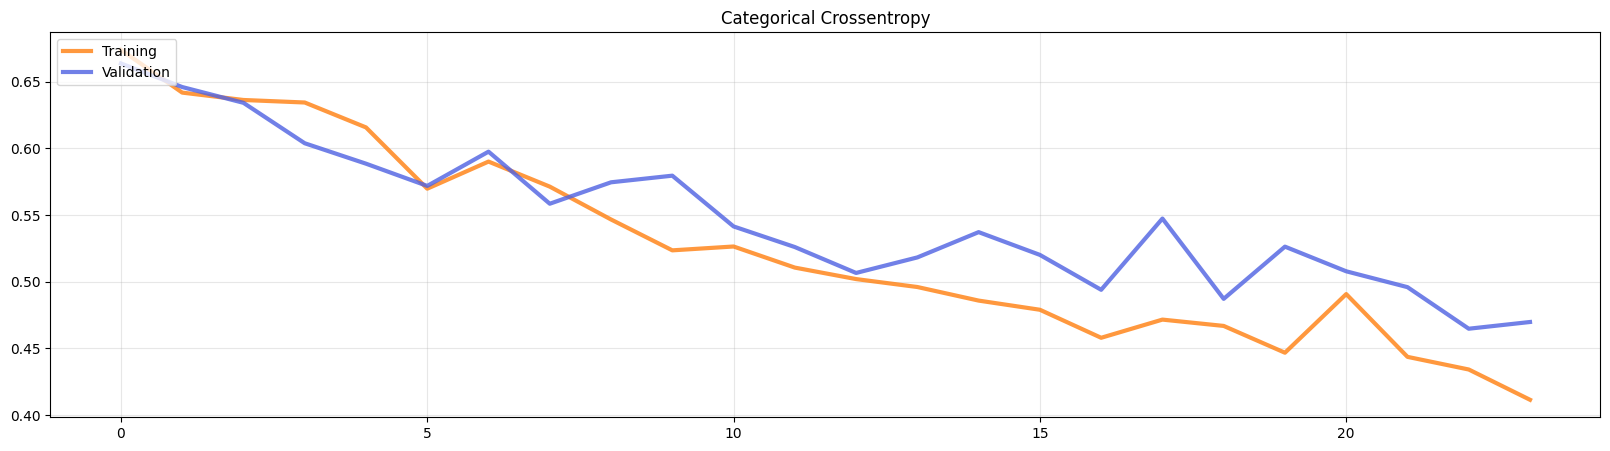

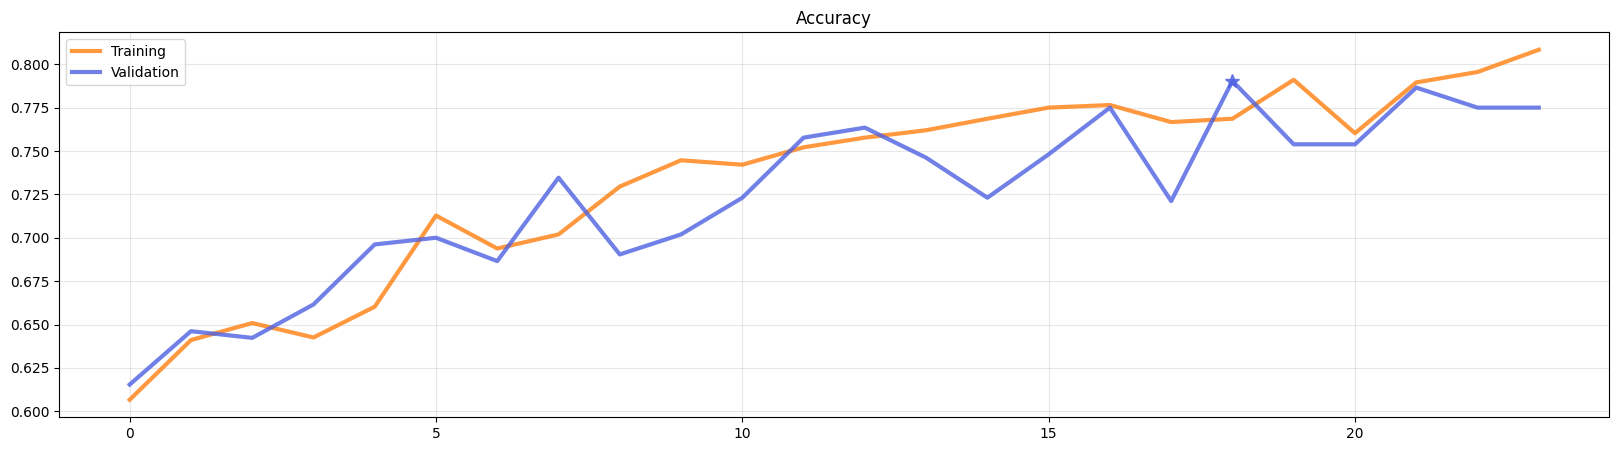

In [31]:
# Find the epoch with the highest validation accuracy
best_epoch = np.argmax(history['val_accuracy'])

# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.plot(best_epoch, history['val_accuracy'][best_epoch], marker='*', alpha=0.8, markersize=10, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [33]:
# Predict labels for the entire validation set
predictions = model.predict(X_val, verbose=0)
accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

# Validation accuracy
print(f'Validation accuracy: {accuracy:.4f}')

Validation accuracy: 0.7904
